# Titanic Survival Exploration

## Getting Started

Loading the dataset and displaying some of its rows.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', palette='deep')
%matplotlib inline

# Set a random seed
import random
random.seed(33)

# Load the datasets
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

In [2]:
# Print the first few entries of the Train Titanic data
df_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
# Print the first few entries of the Test Titanic data
df_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


The Survived column in training set is the target variable. If Suvival = 1 the passenger survived, otherwise he's dead.

## Preprocessing the data

In [2]:
# Concatenating kaggle Train and Test dataframes
features = pd.concat([df_train.drop('Survived', axis=1), df_test])

Checking null values in the dataframe

In [3]:
features.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

The count variable shows that 263 values are missing in the Age feature, 1 in the Fare feature, 1014 in Cabin and 2 in the Embarked feature.

In [4]:
from collections import Counter

Counter(features['Embarked'])

Counter({'S': 914, 'C': 270, 'Q': 123, nan: 2})

Since Cabin Feature has an important part of missing values, I decided to drop it.

One solution for Age and Fare feature is to fill in the null values with the median. For Embarked Column let's fill with the most common value that is "S"

In [5]:
# Drop Cabin
features = features.drop('Cabin', axis=1)

# Fill blanks in Age and Fare with median
features['Age'] = features['Age'].fillna(features['Age'].median())
features['Fare'] = features['Fare'].fillna(features['Fare'].median())

# Fill blanks in Embarked with "S"
features['Embarked'] = features['Embarked'].fillna('S')

Let's check the result.

In [6]:
features.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [7]:
# Splitting data
X_train = features[:len(df_train)]
X_test = features[-(len(df_test)):]
y_train = pd.DataFrame(df_train['Survived'])

# Full train data
df_full = pd.concat([X_train, y_train], axis=1)

## Exploratory data analysis

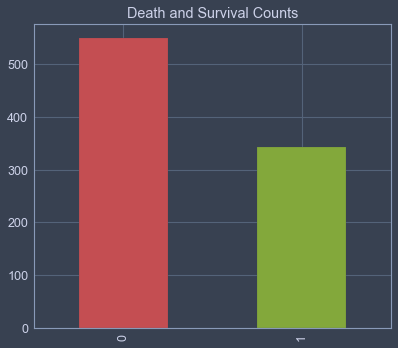

In [24]:
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')

df_full['Survived'].value_counts().plot(kind='bar', title='Death and Survival Counts',grid=True, color=['r', 'g'])
plt.show()

Most of the people did not survive the accident

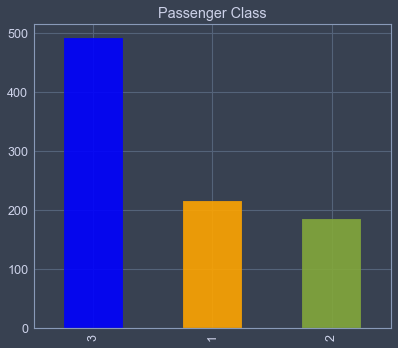

In [25]:
df_full['Pclass'].value_counts().plot(kind='bar', title='Passenger Class',alpha=0.90,grid=True, color=['blue', 'orange', 'g'])
plt.show()

The largest number of passengers were in class 3 followed by class 1 and class 2.

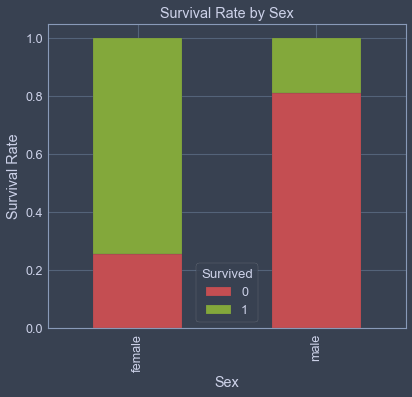

In [26]:
surv_by_sex=pd.crosstab(df_full['Sex'],df_full['Survived'])
surv_by_sex_normalize = surv_by_sex.div(surv_by_sex.sum(1).astype(float),axis=0)
surv_by_sex_normalize.plot(kind='bar',title='Survival Rate by Sex',stacked=True,grid=True, color=['r', 'g']) 
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.show()

The majority of females survived but majority of males did not

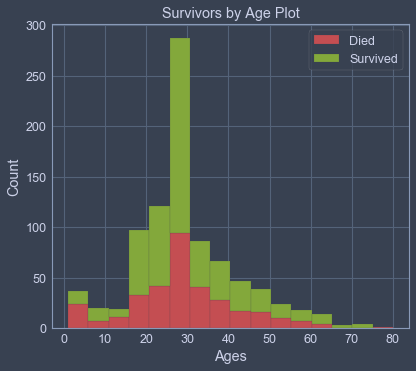

In [27]:
survived = df_full[df_full['Survived'] == 1]
not_survived = df_full[df_full['Survived'] == 0]
max_age = max(df_full['Age'])

plt.hist([survived['Age'],not_survived['Age']],bins=16,range=(1, max_age),stacked=True, color=['r', 'g'])
plt.title('Survivors by Age Plot')
plt.xlabel('Ages')
plt.ylabel('Count')
plt.legend(('Died', 'Survived'))
plt.show()

Let's see about male survivors

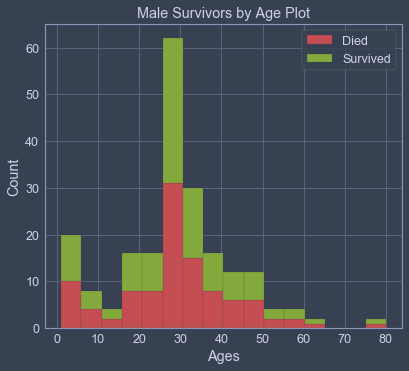

In [28]:
survived_male = survived[survived['Sex'] == 'male']
not_survived_male = survived[survived['Sex'] == 'male']

plt.hist([survived_male['Age'],not_survived_male['Age']],bins=16,range=(1, max_age),stacked=True, color=['r', 'g'])
plt.title('Male Survivors by Age Plot')
plt.xlabel('Ages')
plt.ylabel('Count')
plt.legend(('Died', 'Survived'))
plt.show()


It seems that young male tend to survive and a large number of passengers between 20 and 40 passed away

In [8]:
# Create "Title" feature from the Name feature
features['Title'] = features.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

# Drop Name feature
features = features.drop('Name', axis=1)

In [9]:
# Create "Women_Children" feature

women_children = []
for _, passenger in features.iterrows():
    if passenger['Sex'] == 'female' or passenger['Age'] <= 16:
        women_children.append(1)
    else:
        women_children.append(0)
    
women_children = pd.Series(women_children)

features['women_children'] = women_children

Let's check the result

In [10]:
features.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,women_children
0,1,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr,0
1,2,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs,1
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1


## Training and testing first model with Logistic Regression

In [11]:
# turn off warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [12]:
# Create dummies features and drop useless features
data_dummies = pd.get_dummies(features.drop('Fare', axis=1).drop('SibSp', axis=1))

X_train = data_dummies[:len(df_train)]
X_test = data_dummies[-(len(df_test)):]

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, np.ravel(y_train))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy for training
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(y_train, y_train_pred)
print('The training accuracy is', train_accuracy)

The training accuracy is 0.8933782267115601


This Regression model got a score of 0.78468 on Kaggle

## Saving Predictions CSV file

In [15]:
# Prediction.csv for kaggle competition

def predictions_to_csv(y, file_name):
    '''This function save a predictions array to csv file'''
    df = pd.DataFrame()
    df['PassengerId'] = X_test['PassengerId']
    df['Survived'] = y
    df.to_csv(file_name, index=False)

# Save CSV
predictions_to_csv(y_test_pred, 'first-predictions.csv')

## Improving the models

Hyperparameter optimization with GridSearch

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, make_scorer

def gridsearch_train(model, param_grid):
    '''This function runs a GridSearchCV for a model and train it with training dataframe.
    model: model for hyperparameter optimization.
    param_grid: dictionary with parameters name as key and lists of parameters settings as values.
    '''
    scorer = make_scorer(f1_score)
    grid_obj = GridSearchCV(model, param_grid, scoring=scorer, cv=3)
    grid_fit = grid_obj.fit(X_train, np.ravel(y_train))

    # Get the best estimator
    best_clf = grid_fit.best_estimator_
    
    return best_clf.fit(X_train, y_train)

In [35]:
# Import the classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Model
decision_tree = DecisionTreeClassifier(random_state=33)

# Parameters for decision tree
dtree_param = {'max_depth':[None,2,4,6,8,10,12,14],'min_samples_leaf':[2,4,6,8,10,12,14],'min_samples_split':[2,4,6,8,10,12,14]}

# Training model with GridSearch
best_dtree_clf = gridsearch_train(decision_tree, dtree_param)

# Make predictions for train dataset
best_train_predictions = best_dtree_clf.predict(X_train)

# Calculate the accuracy
train_accuracy = accuracy_score(y_train, best_train_predictions)
print('Decision Tree accuracy =', train_accuracy)

# Calculate the f1_score of the new model
print('Decision Tree F1 Score =', f1_score(y_train, best_train_predictions, average='weighted', labels=np.unique(best_train_predictions)))

Decision Tree accuracy = 0.8451178451178452
Decision Tree F1 Score = 0.8436251052393938


In [50]:
# Save predicts to csv
y_test_pred = best_dtree_clf.predict(X_test)

predictions_to_csv(y_test_pred, 'dtree-predictions.csv')

This Decision Tree got a score of 0.73205 on Kaggle

## RandomForest

In [110]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
RandomForest = RandomForestClassifier(random_state=33, n_estimators=500)

randf_param = {'max_depth':[None,2,4,6],
               'min_samples_leaf':[1,3,10],
               'min_samples_split':[2,5,10],
               'bootstrap': [True, False],
               'criterion': ['gini']}

# Training model with GridSearch
best_randf_clf = gridsearch_train(RandomForest, randf_param)

# Make predictions for train dataset
best_train_predictions = best_randf_clf.predict(X_train)

# Calculate the accuracy
print('RandomForest Accuracy =', accuracy_score(y_train, best_train_predictions))

# Calculate the f1_score of the new model
print('RandomForest F1 Score =', f1_score(y_train, best_train_predictions, average='weighted', labels=np.unique(best_train_predictions)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

RandomForest Accuracy = 0.9775533108866442
RandomForest F1 Score = 0.9775892384588036


In [111]:
# Save predicts to csv
y_test_pred = best_randf_clf.predict(X_test)

predictions_to_csv(y_test_pred, 'randf-predictions.csv')

This Random Forest got a score of 0.80861 on Kaggle

## Logistic Regression

In [109]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(random_state=33)

lr_param = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1], 'solver':['warn']}

# Training model with GridSearch
best_lr_clf = gridsearch_train(logistic_regression, lr_param)

# Make predictions for train dataset
best_train_predictions = best_lr_clf.predict(X_train)

# Calculate the accuracy
print('Logistic Regression accuracy =', accuracy_score(y_train, best_train_predictions))

# Calculate the f1_score of the new model
print('Logistic Regression F1 Score =', f1_score(y_train, best_train_predictions, average='weighted', labels=np.unique(best_train_predictions)))

Logistic Regression accuracy = 0.8933782267115601
Logistic Regression F1 Score = 0.892067424065327


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [87]:
# Save predicts to csv
y_test_pred = best_lr_clf.predict(X_test)

predictions_to_csv(y_test_pred, 'LogReg-predictions.csv')

This Regression model got a score of 0.78468 on Kaggle

## KNeighbors Classifier

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn_param = {'metric': ['minkowski','euclidean','manhattan'] , 'weights': ['uniform','distance'], 'n_neighbors': np.arange(1,10)}

# Training model with GridSearch
best_knn = gridsearch_train(knn, knn_param)

# Make predictions for train dataset
best_train_predictions = best_knn.predict(X_train)

# Calculate the accuracy
print('KNeighbors Classifier accuracy =', accuracy_score(y_train, best_train_predictions))

# Calculate the f1_score of the new model
print('KNeighbors Classifier F1 Score =', f1_score(y_train, best_train_predictions, average='weighted', labels=np.unique(best_train_predictions)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

KNeighbors Classifier accuracy = 0.8226711560044894
KNeighbors Classifier F1 Score = 0.8173278784437217


In [30]:
# Save predicts to csv
y_test_pred = best_knn.predict(X_test)

predictions_to_csv(y_test_pred, 'KNeighbors-predictions.csv')

This KNeighbors Classifier model got a score of 0.64593 on Kaggle

## Gradient Boosting Classifier

In [112]:
from sklearn.ensemble import GradientBoostingClassifier

GBClf = GradientBoostingClassifier(random_state=33)

GBoost_param = {'learning_rate':[i/10.0 for i in range(1,6)],'n_estimators':[500], 'subsample':[i/10.0 for i in range(5,8)]}

# Training model with GridSearch
best_GBClf = gridsearch_train(GBClf, GBoost_param)

# Make predictions for train dataset
best_train_predictions = best_GBClf.predict(X_train)

# Calculate the accuracy
print('Gradient Boosting accuracy =', accuracy_score(y_train, best_train_predictions))

# Calculate the f1_score of the new model
print('Gradient Boosting F1 Score =', f1_score(y_train, best_train_predictions))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression accuracy = 0.9988776655443322
Logistic Regression F1 Score = 0.9985358711566619


In [ ]:
# Save predicts to csv
y_test_pred = best_GBClf.predict(X_test)

predictions_to_csv(y_test_pred, 'XGBoost-predictions.csv')

This Gradient Boosting model got a score of 0.74641 on Kaggle